We're going to discuss how to make a shear-moment-torque plot.  This is intended as a supplementary reference for the full blog post:
 - https://www.m4-engineering.com/insights/technical-blog/

# CORD2R definition



### Imports

In [1]:
import os
import unittest
import getpass
from pathlib import Path
from IPython.display import Latex

import numpy as np
from cpylog import get_logger
import matplotlib.pyplot as plt

import pyNastran
from pyNastran.bdf.bdf import BDF, read_bdf, CORD2R
from pyNastran.op2.op2_geom import read_op2_geom
from pyNastran.bdf.mesh_utils.cut_model_by_plane import get_element_centroids, get_stations
from pyNastran.op2.tables.ogf_gridPointForces.smt import smt_setup, plot_smt
from pyNastran.utils.nastran_utils import run_nastran

PKG_PATH = Path(pyNastran.__path__[0])
REL_MODEL_PATH = PKG_PATH / '..' / 'models'
MODEL_PATH = REL_MODEL_PATH.resolve()
BWB_PATH = MODEL_PATH / 'bwb'

#print(f'BWB_PATH = {BWB_PATH}')
bdf_filename = BWB_PATH / 'bwb_saero.bdf'
op2_filename = BWB_PATH / 'bwb_saero.op2'
bdf_filename_out = BWB_PATH / 'bwb_saero_smt.bdf'

### Run Nastran if the OP2 doesn't already exist

In [2]:
if not os.path.exists(op2_filename):
    keywords_dict = {
        'scr' : 'yes',
        'old' : 'no',
        'mem' : '1024mb',
    }
    run_nastran(bdf_filename, keywords=keywords_dict, cleanup=True)

### Load the Model

We're going to use the read_op2_geom function to read the model.  It's a combination BDF/OP2 classes, so we'll have access to the geometry and results.

In [3]:
log = get_logger(level='critical')
op2_filename = BWB_PATH / 'bwb_saero.op2'
model = read_op2_geom(
    op2_filename,
    include_results='grid_point_forces',
    validate=True, xref=True,
    build_dataframe=False,
    mode='msc', log=log)
log = model.log
log.level = 'debug'


### Basic setup

We need to get the RealGridPointForceArray as well as setup some 
data the shear-moment-torque plotter will use including basic nodal data:
 - nids:           node ids in the model (GRIDs and SPOINTs)
 - nid_cd:         the node id and CD coordinate frame
 - xyz_cid0:       node locations in the basic coordinate system (coord=0 frame)
 - icd_transform:  a map of the GRID's CD/output coordinate frame to node ids

as well as some elemental data:
 - eids:                    element ids
 - element_centroids_cid0:  the element centroids

In [4]:
gpforce = model.grid_point_forces[1]
from pyNastran.op2.tables.ogf_gridPointForces.smt import smt_setup

(nids, nid_cd, xyz_cid0, icd_transform, 
 eids, element_centroids_cid0) = smt_setup(model)

### Get the validation nodes/elements for calculating Interface Loads

As discussed in the blog post, the best way to determine the internal loads is to
get all the elements on one side of the cut (including the cut line), and only the nodes on he boundary elements.

Using the **highlight menu** in the pyNastran GUI, we can select the desired nodes.  An abbreviated format (that is also used by Patran) is supported.

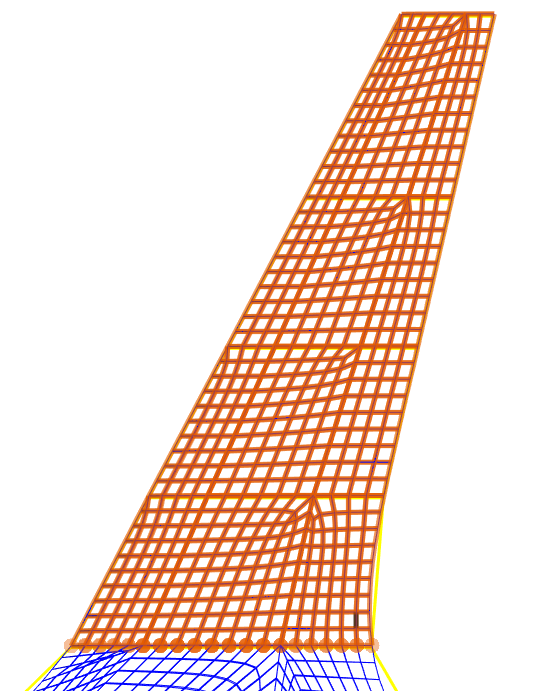

In [5]:
data_str = (
    'Node 1827 1828 4288 4289 4290 4291 1201827 1202604 1887:1891 1893:1898 2588:2611 4311:4315 1202605:1202611 '
    'Elm 1396 1397 1398 1399 1418 1419 1749 1750 1751 1752 2010 2011 2012 2620 2621 2639 2640 2641 1247:1251 1344:1363 1372:1380 1526:1536 1766:1774 1842:1851 2141:2152 2310:2321 2342:2365 2569:2577 2801:2956 3081:3246 3683:3742 3855:3920 4506:4603 4968:5047 5070:5175 5298:5469 5494:5565 5837:5954'
)
from pyNastran.bdf.utils import parse_patran_syntax_dict
nodes_elems_dict = parse_patran_syntax_dict(data_str)
cut_nids = nodes_elems_dict['Node']
cut_eids = nodes_elems_dict['Elm']


origin = np.array([1125.529, 566.6673, 38.76809])
zaxis = origin + np.array([0., 0., 1.])
xzplane = origin + np.array([0., -1., 0.])
summation_point = origin

cut_coord = CORD2R(2, origin, zaxis, xzplane)
force_sumi, moment_sumi = gpforce.extract_interface_loads(
    cut_nids, cut_eids,
    cut_coord, model.coords,
    nid_cd, icd_transform,
    xyz_cid0, debug=False,
    summation_point=summation_point)
force_sumi /= 1000.   # lbf -> kips
moment_sumi /= 1000.  # in-lbf -> in-kips
print('force_sum  (kips)      = ', force_sumi)
print('moment_sum (inch-kips) = ', moment_sumi)

force_sum  (kips)      =  [-3.9062502e-06  2.4414064e-07 -1.2628213e+02]
moment_sum (inch-kips) =  [-1.0558986e+04 -4.3460098e+04  2.9999999e-02]


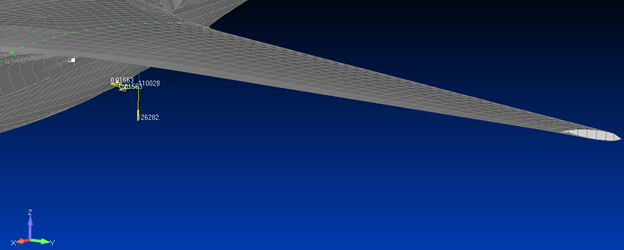

### Shear/Moment Diagram - Define March Direction

If we simply sum moment over a single point, we'll end up with 
a very large moment.  What we want is a series of coordinate 
systems and to plot the loads about that particular point.

This will require a bit more work as what we want is to march from 
the wing tip to the root of the vehicle.  More specifically, we're
going to march from the 25% of the length of the way down the 
tip chord (length of the wing tip) to roughly where projection of
the wing's 25% chord line intersects with the centerline (the buttline!) of the aircraft.

We'll be starting from:

    p1 = [1388.9, 1262.0, 86.3471] inches
    
With the ending location being:

    p3 = [910.93, 0.1, 0.0] inches

In [6]:
# defines the starting point for the shear, moment, torque plot
p1 = np.array([1388.9, 1262.0, 86.3471])  # 1/4c wing_tip; point A; inches

# defines the end point for the shear, moment, torque plot
p3 = np.array([910.93, 0.1, 0.0])  # 1/4c wing_root; inches

Additionally, we're going to orient the output coordinate system such that:
 - x: towards the centerline (-global y)
 - y: aft (global x)
 - z: upwards (global z)

As a bit of a side note, the Nastran coordinate systems use the following series of equations.  The inputs are:
 - A: origin
 - B: origin + z_axis
 - C: origin + xz_plane

Using simple math we can get the $x$, $y$ and $z$ axes:
 - z_axis = B - A
 - xz_plane = B - A
 - y_axis = z_axis × xz_plane
 - x_axis = z_axis × y_axis
 
Normalize those axes to get the $\hat{i}$,  $\hat{j}$, and $\hat{k}$ vectors.

We still need to define an output coordinate system
that shifts as we march down the wing.  This defines the output XZ-plane.

In [7]:
method = 'CORD2R'

zaxis = p1 + np.array([0., 0., 1.])  # point B
# defines the XZ plane for the shears/moments
p2 = p1 + np.array([0., -1., 0.])  # point C

Let's make some coordinate systems.  Really, we're going to make a single coordinate system (coord_out) and then offset it by a series of stations.

The stations we just defined will start from $p_1$ and go to $p_3$, 
so we're simply defining an evenly spaced set of steps.

In [8]:
print(f'p1 = {p1}')
print(f'p2 = {p2}')
print(f'p3 = {p3}')
print(f'zaxis = {zaxis}')
print(f'method = {method}')

p1 = [1388.9    1262.       86.3471]
p2 = [1388.9    1261.       86.3471]
p3 = [9.1093e+02 1.0000e-01 0.0000e+00]
zaxis = [1388.9    1262.       87.3471]
method = CORD2R


In [9]:
method = 'CORD2R'
zaxis = p1 + np.array([0., 0., 1.])  # point B
# defines the XZ plane for the shears/moments
p2 = p1 + np.array([0., -1., 0.])  # point C

print(f'p1 = {p1}')
print(f'p2 = {p2}')
print(f'p3 = {p3}')

xyz1, xyz2, xyz3, i, k, coord_out, iaxis_march, stations = get_stations(
    model, p1, p2, p3, zaxis,
    method=method, nplanes=50)

print(f'i = {i}')
print(f'k = {k}')
print(f'iaxis_march = {iaxis_march}')
print(f'xyz1 = {xyz1}')
print(f'xyz2 = {xyz2}')
print(f'xyz3 = {xyz3}')
print(f'zaxis = {zaxis}')
print(f'method = {method}')

p1 = [1388.9    1262.       86.3471]
p2 = [1388.9    1261.       86.3471]
p3 = [9.1093e+02 1.0000e-01 0.0000e+00]
i = [ 0. -1.  0.]
k = [0. 0. 1.]
iaxis_march = [-0.35348955 -0.9332562  -0.06385923]
xyz1 = [1388.9    1262.       86.3471]
xyz2 = [1388.9    1261.       86.3471]
xyz3 = [9.1093e+02 1.0000e-01 0.0000e+00]
zaxis = [1388.9    1262.       87.3471]
method = CORD2R


# Alternate method using vectors

In [10]:
zaxis = np.array([0., 0., 1.])  # z  becomes k
p2 = np.array([0., -1., 0.])    # xz becomes i
method = 'Vector'
print(f'p3 = {p3}')  # good
xyz1, xyz2, xyz3, i, k, coord_out, iaxis_march, stations = get_stations(
    model, p1, p2, p3, zaxis,
    method=method, nplanes=50)
print(f'i = {i}')
print(f'k = {k}')

print(f'iaxis_march = {iaxis_march}')
print(f'xyz1 = {xyz1}')
print(f'xyz2 = {xyz2}')
print(f'xyz3 = {xyz3}')
print(f'method = {method}')

p3 = [9.1093e+02 1.0000e-01 0.0000e+00]
i = [ 0. -1.  0.]
k = [0. 0. 1.]
iaxis_march = [-0.35348955 -0.9332562  -0.06385923]
xyz1 = [1388.9    1262.       86.3471]
xyz2 = [1388.9    1261.       86.3471]
xyz3 = [9.1093e+02 1.0000e-01 0.0000e+00]
method = Vector


### Calculate the output y-locations

The stations can be used, but for the sake of clarity:

In [11]:
nstations = len(stations)
coord_origins = np.zeros((nstations, 3))
for istation, station in enumerate(stations):
    coord_origin = coord_out.origin + iaxis_march * station
    coord_origins[istation, :] = coord_origin
ylocations = coord_origins[:, 1]

### Calculate a series of force/moment summations at each station

**nodes_tol** is not required (the distance between the first two stations is used as the default), but it's good practice to include it.  1 rows of extra nodes is enough, but to be safe, a few extra rows can be used.  Here, 25 inches or 0.2% of the half-span (the critical direction for the cutting plane) is used.

In [12]:
# i/j/k vector is nan
print(f'origin: {coord_out.origin}')
print(f'zaxis: {coord_out.e2}')
print(f'xzplane: {coord_out.e3}')

force_sum, moment_sum, new_coords, nelems, nnodes = gpforce.shear_moment_diagram(
    nids, xyz_cid0, nid_cd, icd_transform,
    eids, element_centroids_cid0,
    stations, model.coords, coord_out,
    iaxis_march=iaxis_march, # defaults to coord_out.i
    itime=0,
    nodes_tol=25., log=model.log)


origin: [1388.9    1262.       86.3471]
zaxis: [1388.9    1262.       87.3471]
xzplane: [1388.9    1261.       86.3471]


### Write out a BDF of our new coordinate systems to validate the model

In [13]:
for cid, coord in new_coords.items():
    model.coords[cid] = coord
print(model.coords[110028])
model.sol = 144  # not saved to the OP2
model.write_bdf(bdf_filename_out)

CORD2R    110028        1125.529566.667338.768091125.529566.667339.76809
        1125.529565.667338.76809



### Create some plots

Our model has units of inch-lbf-s.  As loads are large, 
we'll be outputting forces in units of kips (1 kip=1000 lbf=1 klbf).
Similarly, we'll divide our moments by 1000 to get from in-lbf to in-kips.

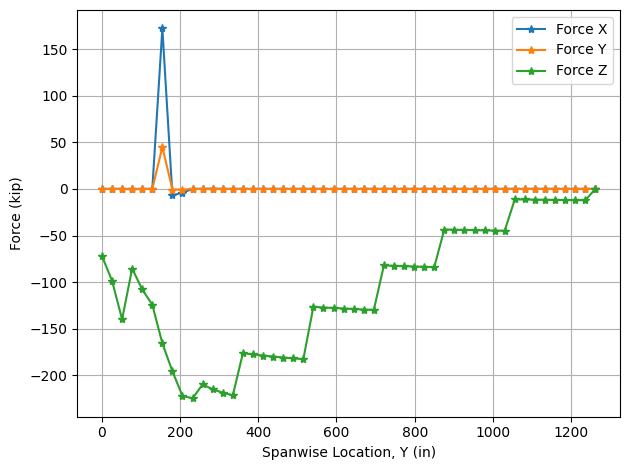

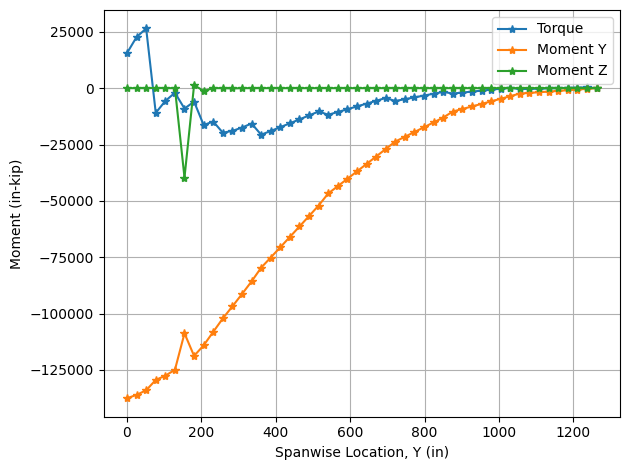

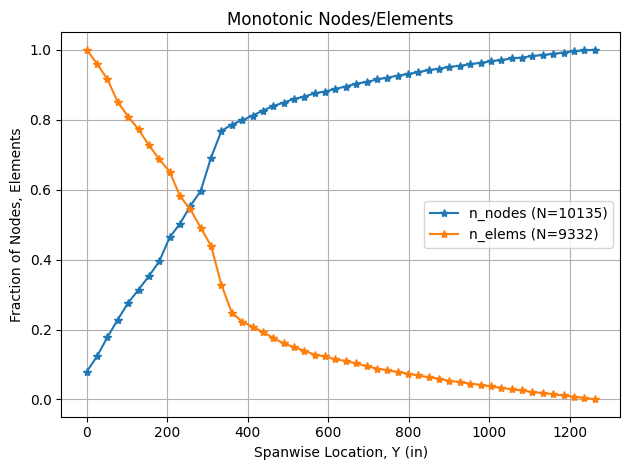

In [14]:
plot_smt(ylocations, force_sum/1000, moment_sum/1000, nelems, nnodes,
         plot_force_components=False,
         plot_moment_components=False,
         #root_filename=os.path.join(BWB_PATH, 'bwb'),
         show=True,
         xtitle='Y', xlabel='Spanwise Location, Y (in)',
         force_unit='kip', moment_unit='in-kip')